In [1]:
import numpy as np
import pandas as pd
import time

# @param dfFile: pandas.DataFrame ('nba_preprocessed.csv')
# @param dateStart, dateEnd: str in the format of 'YYYY-MM-DD'
# @param attriToDrop: list[str]
# @return X, Y: pandas.DataFrame
# featureExtraction() outputs X, Y for model training.
# Game date can be assigned
# Attribute to be dropped can be assigned
def featureExtraction(dfFile, dateStart='1000-01-01', dateEnd='2999-12-31', attriToDrop=None):
    df = pd.read_csv(dfFile)
    
    # Date selection
    df = df.loc[(df.Date_A > dateStart) & (df.Date_A < dateEnd), :].reset_index(drop=True)
    
    # Get label Y
    Y = df[['W/L_A']]
    Y = Y.rename(columns={'W/L_A': 'Label'})
    
    # Get attributes X
    attriToDrop = [x + '_A' for x in attriToDrop] + [x + '_B' for x in attriToDrop] if attriToDrop else []
    colToDrop = ['Team_A', 'Date_A', 'W/L_A', 'Score_A', 'Opponent_A', 'Team_B', 'Date_B', 'W/L_B', 'Home/Away_B', 'Score_B', 'Opponent_B']
    colToDrop += attriToDrop if attriToDrop else []
    X = df.drop(columns = colToDrop)
    
    return X, Y

In [2]:
import random
import sys
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from datetime import datetime

warnings.filterwarnings(action='ignore', category=DeprecationWarning)

def StackingMethod2(origin_df_X, origin_df_Y, kfold=10, is_debug=0, **all_basic_classifiers):
    X_train = origin_df_X.values
    Y_train = origin_df_Y.values.ravel()
    random.seed(datetime.now())
    skf = StratifiedKFold(n_splits=kfold, random_state=random.randint(0, 2**32-1), shuffle=True)
    iteration = 0
    len_y = 0
    new_feature_columns = ['Label_'+x for x in all_basic_classifiers.keys()]
    new_feature_arr     = np.zeros([len(X_train), len(new_feature_columns)])
    model_dict = {}
    
    #Initialize the model list for every classifier
    for k in all_basic_classifiers.keys():
        model_dict[k] = []
    
    for train_index, test_index in skf.split(X_train, Y_train):
        X_cv_train = X_train[train_index]
        Y_cv_train = Y_train[train_index]
        X_cv_test  = X_train[test_index]
        Y_cv_test  = Y_train[test_index]
        column_label_index = 0
        
        if(is_debug):
            print(f"-----iteration {iteration}-----")
            print(f'test_index = {test_index}')
        for k, v in all_basic_classifiers.items():
            classifier_cv = v
            classifier_cv.fit(X_cv_train, Y_cv_train)
            model_dict[k].append(classifier_cv)
            Y_cv_test_result = classifier_cv.predict(X_cv_test)
            count_result_index = 0
            for index in test_index:
                new_feature_arr[index][column_label_index] = Y_cv_test_result[count_result_index]
                count_result_index += 1
                
            column_label_index += 1
            
            if(is_debug):
                len_y += len(Y_cv_test_result)
                print(f'key = {k}, val = {v}')
                print(f'Y_cv_test_result = {Y_cv_test_result}')
                print(f'len(Y_cv_test_result) = {len(Y_cv_test_result)}')
                print(type(Y_cv_test_result))
                print('-------')
        iteration += 1
        
    new_feature_df = pd.DataFrame(data = new_feature_arr, columns = new_feature_columns)
    output_df_all = pd.concat([origin_df_X, new_feature_df], axis=1, ignore_index=False)
    
    if(is_debug):
        print(f'total len_y = {len_y}')
        print(f'new_feature_columns = {new_feature_columns}')
        count_index_fin = 0
        for x in new_feature_arr:
            print(f'index = {count_index_fin}, label = {x}')
            count_index_fin += 1
        
    return (output_df_all, model_dict)

In [3]:
import random
import sys
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from datetime import datetime

warnings.filterwarnings(action='ignore', category=DeprecationWarning)

def StackingMethod(origin_df_X, origin_df_Y, kfold=10, is_debug=0, **all_basic_classifiers):
    X_train = origin_df_X.values
    Y_train = origin_df_Y.values.ravel()
    random.seed(datetime.now())
    skf = StratifiedKFold(n_splits=kfold, random_state=random.randint(0, 2**32-1), shuffle=True)
    iteration = 0
    len_y = 0
    new_feature_columns = ['Label_'+x for x in all_basic_classifiers.keys()]
    new_feature_arr     = np.zeros([len(X_train), len(new_feature_columns)])
    model_dict = {}
    
    #Initialize the model list for every classifier
    for k in all_basic_classifiers.keys():
        model_dict[k] = []
    
    for train_index, test_index in skf.split(X_train, Y_train):
        X_cv_train = X_train[train_index]
        Y_cv_train = Y_train[train_index]
        X_cv_test  = X_train[test_index]
        Y_cv_test  = Y_train[test_index]
        column_label_index = 0
        
        if(is_debug):
            print(f"-----iteration {iteration}-----")
            print(f'test_index = {test_index}')
        for k, v in all_basic_classifiers.items():
            classifier_cv = v
            classifier_cv.fit(X_cv_train, Y_cv_train)
            model_dict[k].append(classifier_cv)
            Y_cv_test_result = classifier_cv.predict(X_cv_test)
            count_result_index = 0
            for index in test_index:
                new_feature_arr[index][column_label_index] = Y_cv_test_result[count_result_index]
                count_result_index += 1
                
            column_label_index += 1
            
            if(is_debug):
                len_y += len(Y_cv_test_result)
                print(f'key = {k}, val = {v}')
                print(f'Y_cv_test_result = {Y_cv_test_result}')
                print(f'len(Y_cv_test_result) = {len(Y_cv_test_result)}')
                print(type(Y_cv_test_result))
                print('-------')
        iteration += 1
        
    new_feature_df = pd.DataFrame(data = new_feature_arr, columns = new_feature_columns)
    output_df_all = pd.concat([origin_df_X, new_feature_df], axis=1, ignore_index=False)
    
    if(is_debug):
        print(f'total len_y = {len_y}')
        print(f'new_feature_columns = {new_feature_columns}')
        count_index_fin = 0
        for x in new_feature_arr:
            print(f'index = {count_index_fin}, label = {x}')
            count_index_fin += 1
        
    return (output_df_all, model_dict)

In [4]:
#x_1d_test_array is the 1-dimension test array
def PredictFunctionAggregation(x_1d_test_array, n_estimator, voting=1, is_debug=0):
    ret_val = 0
    if(voting == 1):
        y_predict = [x.predict(x_1d_test_array) for x in n_estimator]
        count_0 = y_predict.count(0)
        count_1 = y_predict.count(1)
        
        if(is_debug):
            print(f'y_predict = {y_predict}')
            print(f'count_0   = {count_0}')
            print(f'count_1   = {count_1}')

        if(count_0 > count_1):
            ret_val = 0
        else:
            ret_val = 1
    else:
        y_predict = [x.predict_proba(x_1d_test_array) for x in n_estimator]
        if(is_debug):
            print(f'y_predict = {y_predict}')
        #return the probability that is 1(left wins)     
        total_1_prob = [x[0][1] for x in y_predict]
        ret_val = np.mean(total_1_prob)
    
    return ret_val

In [5]:
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

#Only support roc_auc scoring now
def CrossValidationGetModelsScores(origin_df_X, origin_df_Y, fold_num, est_classifier, est_name):
    X_data = origin_df_X.values
    Y_data = origin_df_Y.values.ravel()
    random.seed(datetime.now())
    skf = StratifiedKFold(n_splits=fold_num, random_state=random.randint(0, 2**32-1), shuffle=True)
    ret_n_estimator = []
    ret_n_score     = []
    new_feature_columns = ['Label_'+est_name]
    new_feature_arr     = np.zeros([len(X_data), len(new_feature_columns)])
    
    for train_index, test_index in skf.split(X_data, Y_data):
        X_cv_train = X_data[train_index]
        Y_cv_train = Y_data[train_index]
        X_cv_test  = X_data[test_index]
        Y_cv_test  = Y_data[test_index]
        
        ret_n_estimator.append(est_classifier)
        ret_n_estimator[-1].fit(X_cv_train, Y_cv_train)
        Y_cv_pred = ret_n_estimator[-1].predict(X_cv_test)
        
        count_result_index = 0
        for index in test_index:
            new_feature_arr[index][0] = Y_cv_pred[count_result_index]
            count_result_index += 1
        
        #ret_n_score.append(roc_auc_score(Y_cv_test, ret_n_estimator[-1].predict(X_cv_test)))
        
    new_feature_df = pd.DataFrame(data = new_feature_arr, columns = new_feature_columns)
    output_df_all = pd.concat([origin_df_X, new_feature_df], axis=1, ignore_index=False)
    return(ret_n_estimator, output_df_all)

In [6]:
#x_1d_test_array is the 1-dimension test array
def PredictFunctionAggregation(x_1d_test_array, n_estimator, voting=1, is_debug=0):
    ret_val = 0
    if(voting == 1):
        y_predict = [x.predict(x_1d_test_array) for x in n_estimator]
        count_0 = y_predict.count(0)
        count_1 = y_predict.count(1)
        
        if(is_debug):
            print(f'y_predict = {y_predict}')
            print(f'count_0   = {count_0}')
            print(f'count_1   = {count_1}')

        if(count_0 > count_1):
            ret_val = 0
        else:
            ret_val = 1
    else:
        y_predict = [x.predict_proba(x_1d_test_array) for x in n_estimator]
        if(is_debug):
            print(f'y_predict = {y_predict}')
        #return the probability that is 1(left wins)     
        total_1_prob = [x[0][1] for x in y_predict]
        ret_val = np.mean(total_1_prob)
    
    return ret_val

In [7]:
import matplotlib.pyplot as plt
from tabulate import tabulate
%matplotlib inline

def PrintFeatureImp(origin_df_X, n_final_clf, best_num=10):
    feature_name = np.array(list(origin_df_X.columns))
    feature_imp = np.array([n_final_clf[idx_clf].feature_importances_[0:len(feature_name)] for idx_clf in range(len(n_final_clf))])
    feature_imp = np.mean(feature_imp, axis=0)
    feature_imp = feature_imp/feature_imp.max()
    idx_sorted = np.argsort(feature_imp)[len(feature_imp)+1-best_num:len(feature_imp)+1]

    headers = ["Feature Name", "Feature Importance"]
    values = sorted(zip(feature_name, feature_imp), key=lambda x: -x[1])
    print(tabulate(values[0:best_num], headers, tablefmt="plain"))
    
    bar_pos = np.arange(idx_sorted.shape[0]) + 0.5
    plt.barh(bar_pos, feature_imp[idx_sorted], align='center')
    plt.yticks(bar_pos, feature_name[idx_sorted])
    plt.xlabel('Feature Importance')
    plt.show()

In [8]:
def CatchScoring(func, *args, **kwargs):
    try:
        return func(*args, **kwargs)
    except Exception as e:
        return 0

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

def TotalModelTrain(origin_df_X, origin_df_Y, kfold_num=10, is_debug=0, is_scoring=1, is_print_feature_imp=1, best_num=10, **all_classifiers_dic):
    level_classifier_dic = {}
    final_classifier = {}
    final_clf_name = ""
    level = 0
    count_dic = 0
    model_trained_dic = {}
    
    for name, classifier_dic in sorted(all_classifiers_dic.items()):
        if(count_dic < len(all_classifiers_dic.items())-1):
            level_classifier_dic[name] = classifier_dic
        else:
            final_classifier  = classifier_dic

        count_dic += 1
    
    #Level classifiers
    level_df_X = origin_df_X
    for name, classifier_dic in sorted(level_classifier_dic.items()):
        (level_df_X, model_dict) = StackingMethod(level_df_X, origin_df_Y, kfold_num, is_debug, **classifier_dic)
        model_trained_dic[name] = model_dict
        
        if(is_scoring):
            acc_score_dic  = {name_clf : CatchScoring(accuracy_score, origin_df_Y, level_df_X['Label_'+name_clf]) for name_clf in classifier_dic.keys()}
            roc_score_dic  = {name_clf : CatchScoring(roc_auc_score, origin_df_Y, level_df_X['Label_'+name_clf]) for name_clf in classifier_dic.keys()}
            print(f'------------level_{level+1}------------')
            print('{sp:<32} {x:<20} {y:<15}'.format(sp=" ", x="Accuracy", y="ROC_AUC"))
            for name_clf in classifier_dic.keys():
                print('{name_clf:<35} {acc:<19.3f} {roc_auc:<15.3f}'.format(name_clf=name_clf, acc=acc_score_dic[name_clf], roc_auc=roc_score_dic[name_clf]))
        
        if(is_debug):
            for name, classifier in classifier_dic.items():
                print(f'level {level+1} classifier--->{name} = {classifier}')
        level += 1
    
    #Final classifiers
    for name, classifier in final_classifier.items():
        final_clf_name = name
        if(is_debug):
            print(f'final classifier--->{name} = {classifier}')
        break

    (final_n_estimator, level_df_X) = CrossValidationGetModelsScores(level_df_X, origin_df_Y, kfold_num, final_classifier[final_clf_name], final_clf_name)
    if(is_scoring):
        acc_score_dic  = {final_clf_name : CatchScoring(accuracy_score, origin_df_Y, level_df_X['Label_'+final_clf_name])}
        roc_score_dic  = {final_clf_name : CatchScoring(roc_auc_score, origin_df_Y, level_df_X['Label_'+final_clf_name])}
        print(f'------------level_final------------')
        print('{sp:<32} {x:<20} {y:<15}'.format(sp=" ", x="Accuracy", y="ROC_AUC"))
        print('{name_clf:<35} {acc:<19.3f} {roc_auc:<15.3f}'.format(name_clf=final_clf_name, acc=acc_score_dic[final_clf_name], roc_auc=roc_score_dic[final_clf_name]))
        
    if(is_print_feature_imp):
        if(best_num <= 0):
            print("Error : best_num cannot be <=0.")
            return
        PrintFeatureImp(origin_df_X, final_n_estimator, best_num=best_num)
        
    return (model_trained_dic, final_n_estimator, level_df_X)

In [10]:
def TotalModelTest(origin_df_X, model_trained_dic, final_n_estimator, origin_df_Y=None, is_debug=0, is_scoring=0, voting=1, **all_classifiers_dic):
    X_test               = origin_df_X.values
    level                = 0
    new_feature_columns  = [x for x in origin_df_X.columns]
    new_feature_list     = []
    total_level          = len(all_classifiers_dic.keys())
    final_clf_name       = ""

    if(is_scoring):
        if(origin_df_Y is None):
            print("Error : origin_df_Y should not be None when is_scoring = 1.")
            return
        else:
            Y_test       = origin_df_Y.values.ravel()
            
    #level classifiers to get the spanned features
    for set_name in sorted(all_classifiers_dic.keys()):
        if(level < (total_level-1)):
            new_feature_list = []
            new_feature_pred = {}
            for name in all_classifiers_dic[set_name].keys():
                clf_cv = model_trained_dic[set_name][name]
                Y_cv_test = [[PredictFunctionAggregation(np.array([x]), clf_cv, voting=1, is_debug=is_debug)] for x in X_test]
                new_feature_list.append(Y_cv_test)
                new_feature_columns.append('Label_'+name)
                new_feature_pred[new_feature_columns[-1]] = np.array(new_feature_list[-1]).ravel()
                
                if(is_debug):
                    print(f'set_name = {set_name}')
                    print(f'name     = {name}')
                    print(f'level    = {level}')
                    print(f'clf_cv   = {clf_cv}')
            
            #Append new features to the origin X features set 
            for list_test in new_feature_list:
                list_arr = np.array(list_test)
                X_test = np.concatenate((X_test, list_arr), axis=1)
            if(is_scoring):
                acc_score_dic  = {name_clf : CatchScoring(accuracy_score, Y_test, new_feature_pred['Label_'+name_clf]) for name_clf in all_classifiers_dic[set_name].keys()}
                roc_score_dic  = {name_clf : CatchScoring(roc_auc_score, Y_test, new_feature_pred['Label_'+name_clf]) for name_clf in all_classifiers_dic[set_name].keys()}
                print(f'------------level_{level+1}------------')
                print('{sp:<32} {x:<20} {y:<15}'.format(sp=" ", x="Accuracy", y="ROC_AUC"))
                for name_clf in all_classifiers_dic[set_name].keys():
                    print('{name_clf:<35} {acc:<19.3f} {roc_auc:<15.3f}'.format(name_clf=name_clf, acc=acc_score_dic[name_clf], roc_auc=roc_score_dic[name_clf]))
        else:
            for name in all_classifiers_dic[set_name].keys():
                final_clf_name = name
                break
        level += 1
        
    #final classifiers to get the final result
    Y_cv_test = [[PredictFunctionAggregation(np.array([x]), final_n_estimator, voting=voting, is_debug=is_debug)] for x in X_test]        
    Y_cv_test_arr = np.array(Y_cv_test)
    X_test = np.concatenate((X_test, Y_cv_test_arr), axis=1)

    if(is_scoring):
        acc_score_dic  = {final_clf_name : CatchScoring(accuracy_score, Y_test, Y_cv_test_arr.ravel())}
        roc_score_dic  = {final_clf_name : CatchScoring(roc_auc_score, Y_test, Y_cv_test_arr.ravel())}
        print(f'------------level_final------------')
        print('{sp:<32} {x:<20} {y:<15}'.format(sp=" ", x="Accuracy", y="ROC_AUC"))
        print('{name_clf:<35} {acc:<19.3f} {roc_auc:<15.3f}'.format(name_clf=final_clf_name, acc=acc_score_dic[final_clf_name], roc_auc=roc_score_dic[final_clf_name]))
    
    #finalize the datafrom 
    new_feature_columns.append('Label_'+final_clf_name)
    new_feature_df = pd.DataFrame(data = X_test, columns = new_feature_columns)
    return new_feature_df

In [11]:
dfFile = '../../python_ex/NBA_Ino_Part/nba_preprocessed.csv'
dateStart = '2017-08-01'
dateEnd = '2018-05-01'
# X, Y = featureExtraction(dfFile, dateStart, dateEnd)
X_total, Y_total = featureExtraction(dfFile, attriToDrop=['PTS'], dateStart=dateStart, dateEnd=dateEnd)
# X, Y = featureExtraction(dfFile)

# Example

------------level_1------------
                                 Accuracy             ROC_AUC        
logistic_classifier                 0.997               0.997          
svm_classifier                      0.507               0.499          
naive_bayse_gaussian_classifier     0.899               0.899          
------------level_2------------
                                 Accuracy             ROC_AUC        
rf_classifer                        0.996               0.996          
gbdt_classifier                     0.997               0.997          
xgb_classifier                      0.997               0.997          
------------level_final------------
                                 Accuracy             ROC_AUC        
lgb_classifier                      0.997               0.997          
Feature Name      Feature Importance
FT%_B                      1
FG%_B                      0.775342
3P%_A                      0.526027
FG%_A                      0.454795
FT%_A       

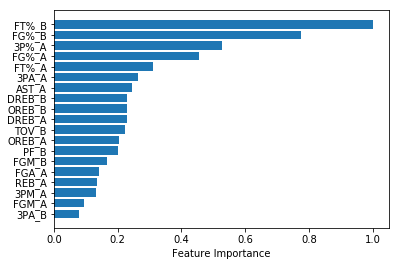

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 

level_1_classifier  = {'logistic_classifier'             : LogisticRegression(),
                       'svm_classifier'                  : SVC(),
                       'naive_bayse_gaussian_classifier' : GaussianNB()}

level_2_classifier  = {'rf_classifer'    : RandomForestClassifier(),
                       'gbdt_classifier' : GradientBoostingClassifier(),
                       'xgb_classifier'  : XGBClassifier()}

final_classifier    = {'lgb_classifier'  : LGBMClassifier()}

all_classifiers_dic = {'level_2_classifier' : level_2_classifier,
                       'level_1_classifier' : level_1_classifier,
                       'level_3_classifier' : final_classifier}

(model_trained_dict, n_final_clf, final_df_x) = TotalModelTrain(X_total[0:1230], Y_total[0:1230], kfold_num=10, is_debug=0, is_scoring=1, is_print_feature_imp=1, best_num=20, **all_classifiers_dic)

In [13]:
final_df_x.head()

,Home/Away_A,FG%_A,FGM_A,FGA_A,3P%_A,3PM_A,3PA_A,FT%_A,FTM_A,FTA_A,...,BLK_B,TOV_B,PF_B,Label_logistic_classifier,Label_svm_classifier,Label_naive_bayse_gaussian_classifier,Label_rf_classifer,Label_gbdt_classifier,Label_xgb_classifier,Label_lgb_classifier
0,0,0.468,36,77,0.481,13,27,0.917,11,12,...,5,15,18,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,0.435,37,85,0.333,10,30,0.600,12,20,...,3,13,21,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1,0.488,39,80,0.348,8,23,0.783,18,23,...,3,15,24,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0,0.384,38,99,0.258,8,31,0.600,9,15,...,5,14,16,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0,0.462,42,91,0.200,4,20,0.739,17,23,...,4,12,21,1.0,1.0,0.0,1.0,1.0,1.0,1.0


In [14]:
X_total.head()

,Home/Away_A,FG%_A,FGM_A,FGA_A,3P%_A,3PM_A,3PA_A,FT%_A,FTM_A,FTA_A,...,FTM_B,FTA_B,REB_B,OREB_B,DREB_B,AST_B,STL_B,BLK_B,TOV_B,PF_B
0,0,0.468,36,77,0.481,13,27,0.917,11,12,...,15,16,36,6,30,28,9,5,15,18
1,1,0.435,37,85,0.333,10,30,0.600,12,20,...,9,13,39,12,27,15,6,3,13,21
2,1,0.488,39,80,0.348,8,23,0.783,18,23,...,26,28,38,10,28,24,13,3,15,24
3,0,0.384,38,99,0.258,8,31,0.600,9,15,...,21,26,49,9,40,18,5,5,14,16
4,0,0.462,42,91,0.200,4,20,0.739,17,23,...,12,12,43,11,32,23,7,4,12,21


In [15]:
model_trained_dict

{'level_1_classifier': {'logistic_classifier': [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False),
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False),
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False),
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_ite

In [16]:
n_final_clf

[LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
         learning_rate=0.1, max_depth=-1, min_child_samples=20,
         min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
         n_jobs=-1, num_leaves=31, objective=None, random_state=None,
         reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
         subsample_for_bin=200000, subsample_freq=1),
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
         learning_rate=0.1, max_depth=-1, min_child_samples=20,
         min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
         n_jobs=-1, num_leaves=31, objective=None, random_state=None,
         reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
         subsample_for_bin=200000, subsample_freq=1),
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
         learning_rate=0.1, max_depth=-1, min_child_samples=20,
         min_child_weight=0.001, min_split_ga

In [17]:
final_df_x['Label'] = Y_total['Label']
final_df_x.head()

,Home/Away_A,FG%_A,FGM_A,FGA_A,3P%_A,3PM_A,3PA_A,FT%_A,FTM_A,FTA_A,...,TOV_B,PF_B,Label_logistic_classifier,Label_svm_classifier,Label_naive_bayse_gaussian_classifier,Label_rf_classifer,Label_gbdt_classifier,Label_xgb_classifier,Label_lgb_classifier,Label
0,0,0.468,36,77,0.481,13,27,0.917,11,12,...,15,18,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,1,0.435,37,85,0.333,10,30,0.600,12,20,...,13,21,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2,1,0.488,39,80,0.348,8,23,0.783,18,23,...,15,24,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0
3,0,0.384,38,99,0.258,8,31,0.600,9,15,...,14,16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,0,0.462,42,91,0.200,4,20,0.739,17,23,...,12,21,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1


In [18]:
X_total.head()

,Home/Away_A,FG%_A,FGM_A,FGA_A,3P%_A,3PM_A,3PA_A,FT%_A,FTM_A,FTA_A,...,FTM_B,FTA_B,REB_B,OREB_B,DREB_B,AST_B,STL_B,BLK_B,TOV_B,PF_B
0,0,0.468,36,77,0.481,13,27,0.917,11,12,...,15,16,36,6,30,28,9,5,15,18
1,1,0.435,37,85,0.333,10,30,0.600,12,20,...,9,13,39,12,27,15,6,3,13,21
2,1,0.488,39,80,0.348,8,23,0.783,18,23,...,26,28,38,10,28,24,13,3,15,24
3,0,0.384,38,99,0.258,8,31,0.600,9,15,...,21,26,49,9,40,18,5,5,14,16
4,0,0.462,42,91,0.200,4,20,0.739,17,23,...,12,12,43,11,32,23,7,4,12,21


In [19]:
X_total[1230:1235]

,Home/Away_A,FG%_A,FGM_A,FGA_A,3P%_A,3PM_A,3PA_A,FT%_A,FTM_A,FTA_A,...,FTM_B,FTA_B,REB_B,OREB_B,DREB_B,AST_B,STL_B,BLK_B,TOV_B,PF_B
1230,0,0.380,30,79,0.280,7,25,0.828,24,29,...,16,28,45,15,30,19,9,8,11,29
1231,1,0.459,45,98,0.444,16,36,0.636,14,22,...,16,20,49,10,39,31,5,8,18,23
1232,0,0.566,47,83,0.313,10,32,0.714,15,21,...,15,20,38,9,29,27,7,6,17,24
1233,0,0.395,30,76,0.300,9,30,0.750,24,32,...,27,33,63,18,45,17,7,7,19,22
1234,0,0.488,42,86,0.406,13,32,0.739,17,23,...,23,25,34,5,29,25,7,5,12,17


In [20]:
Y_total[1230::]

,Label
1230,0
1231,0
1232,1
1233,0
1234,1
1235,1
1236,0
1237,0
1238,1
1239,1


In [21]:
aa_data = [0 if x==1 else 1 for x in Y_total['Label'][1230::]]
aa_data = np.array(aa_data)
Y_aa_data = pd.DataFrame(data = aa_data, columns = ['Label'])
Y_aa_data

,Label
0,1
1,1
2,0
3,1
4,0
5,0
6,1
7,1
8,0
9,0


In [22]:
new_feature_X_df = TotalModelTest(X_total[1230::], model_trained_dict, n_final_clf, Y_total[1230::], is_debug=0, is_scoring=1, voting=1, **all_classifiers_dic)
#new_feature_X_df = TotalModelTest(X_total[1230:1232:], model_trained_dict, n_final_clf, Y_total[1230:1232:], is_debug=0, is_scoring=1, voting=1, **all_classifiers_dic)
#new_feature_X_df = TotalModelTest(X_total[1230:1231:], model_trained_dict, n_final_clf, is_debug=0, is_scoring=0, voting=1, **all_classifiers_dic)
#new_feature_X_df = TotalModelTest(X_total[1230::], model_trained_dict, n_final_clf, Y_aa_data, is_debug=0, is_scoring=1, voting=1, **all_classifiers_dic)
new_feature_X_df.head()

------------level_1------------
                                 Accuracy             ROC_AUC        
logistic_classifier                 0.998               0.998          
svm_classifier                      0.494               0.502          
naive_bayse_gaussian_classifier     0.896               0.896          
------------level_2------------
                                 Accuracy             ROC_AUC        
rf_classifer                        0.997               0.997          
gbdt_classifier                     0.995               0.995          
xgb_classifier                      0.998               0.998          
------------level_final------------
                                 Accuracy             ROC_AUC        
lgb_classifier                      0.998               0.998          


,Home/Away_A,FG%_A,FGM_A,FGA_A,3P%_A,3PM_A,3PA_A,FT%_A,FTM_A,FTA_A,...,BLK_B,TOV_B,PF_B,Label_logistic_classifier,Label_svm_classifier,Label_naive_bayse_gaussian_classifier,Label_rf_classifer,Label_gbdt_classifier,Label_xgb_classifier,Label_lgb_classifier
0,0.0,0.380,30.0,79.0,0.280,7.0,25.0,0.828,24.0,29.0,...,8.0,11.0,29.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.459,45.0,98.0,0.444,16.0,36.0,0.636,14.0,22.0,...,8.0,18.0,23.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.566,47.0,83.0,0.313,10.0,32.0,0.714,15.0,21.0,...,6.0,17.0,24.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,0.395,30.0,76.0,0.300,9.0,30.0,0.750,24.0,32.0,...,7.0,19.0,22.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.488,42.0,86.0,0.406,13.0,32.0,0.739,17.0,23.0,...,5.0,12.0,17.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [23]:
Y_total[1230::]

,Label
1230,0
1231,0
1232,1
1233,0
1234,1
1235,1
1236,0
1237,0
1238,1
1239,1


In [24]:
new_feature_X_df['Label'] = np.array(Y_total[1230::])
new_feature_X_df

,Home/Away_A,FG%_A,FGM_A,FGA_A,3P%_A,3PM_A,3PA_A,FT%_A,FTM_A,FTA_A,...,TOV_B,PF_B,Label_logistic_classifier,Label_svm_classifier,Label_naive_bayse_gaussian_classifier,Label_rf_classifer,Label_gbdt_classifier,Label_xgb_classifier,Label_lgb_classifier,Label
0,0.0,0.380,30.0,79.0,0.280,7.0,25.0,0.828,24.0,29.0,...,11.0,29.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,1.0,0.459,45.0,98.0,0.444,16.0,36.0,0.636,14.0,22.0,...,18.0,23.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.566,47.0,83.0,0.313,10.0,32.0,0.714,15.0,21.0,...,17.0,24.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
3,0.0,0.395,30.0,76.0,0.300,9.0,30.0,0.750,24.0,32.0,...,19.0,22.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.488,42.0,86.0,0.406,13.0,32.0,0.739,17.0,23.0,...,12.0,17.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
5,1.0,0.538,49.0,91.0,0.433,13.0,30.0,0.750,12.0,16.0,...,17.0,19.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
6,1.0,0.459,39.0,85.0,0.250,7.0,28.0,0.778,14.0,18.0,...,16.0,19.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
7,1.0,0.429,36.0,84.0,0.258,8.0,31.0,0.857,18.0,21.0,...,21.0,21.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
8,0.0,0.404,36.0,89.0,0.241,7.0,29.0,0.769,20.0,26.0,...,15.0,24.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
9,0.0,0.402,35.0,87.0,0.290,9.0,31.0,0.773,17.0,22.0,...,17.0,19.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [25]:
index = 0
for x in Y_total['Label'][1230::]:
    if(x != new_feature_X_df['Label_lgb_classifier'][index]):
        print(f"noneq index = {index}")
    index += 1

noneq index = 102
noneq index = 112
noneq index = 275


In [26]:
new_feature_X_df[112:112+1:]

,Home/Away_A,FG%_A,FGM_A,FGA_A,3P%_A,3PM_A,3PA_A,FT%_A,FTM_A,FTA_A,...,TOV_B,PF_B,Label_logistic_classifier,Label_svm_classifier,Label_naive_bayse_gaussian_classifier,Label_rf_classifer,Label_gbdt_classifier,Label_xgb_classifier,Label_lgb_classifier,Label
112,1.0,0.462,42.0,91.0,0.368,7.0,19.0,0.81,17.0,21.0,...,17.0,19.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
